# Binary Model to Determine Above/Below-ground Pipelines
## From USDA Agriculture Aerial Photographs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import folium
import geemap.core as geemap
import geehydro
import math
import requests
import os
import skimage
import rasterio as rs
import time
import torch
import cv2
import PIL
from PIL import Image
from google.cloud import storage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn import svm, metrics, ensemble
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2, l1
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights, 
                                             DeepLabV3_ResNet101_Weights, 
                                            )




### Functions to Import GeoTIFFs from Google Cloud Storage or prep Images

In [10]:
# ensure directories are made if they do not exist
def checkdirs(path):
    if not(os.path.exists(path)):
        os.makedirs(path)

## crop images to middle 256x256 pixels
def crop(img):
    height, width = img.shape[0:2]
    new = 256

    left = int((width - new)/2)
    top = int((height - new)/2)
    right = int((width + new)/2)
    bottom = int((height + new)/2)

    # print(left,top,right,bottom)
    crop = img[top:bottom,left:right,:]
    # print(crop.shape)
    return crop

## get labels from completed csv file
def get_Labels(csvF="400labelsAbs.csv"):
    l = pd.read_csv(csvF)

    found = l.loc[l.Index==1002].Label.squeeze()
    missing = l.loc[l.Index==1003].Label.squeeze()
   

    # print(type(found))
    # print(type(missing))

    labelDF = pd.DataFrame(np.nan,index=list(range(2240)),columns=list(l.columns))

    labelDF.Index = labelDF.index+1
    labelDF.tail()
    for val in list(l.Index.squeeze()):
        label2Add = int(l.loc[l.Index==val].Label.squeeze())
        # print(label2Add)
        labelDF.loc[labelDF.Index==val,"Label"]=label2Add
    labelDF.loc[labelDF.Index==1001]

    # np.array(labelDF)
    return labelDF

def get_sets(csv="400labelsAbs.csv"):
    labelDF = get_Labels(csv)
    imgList = []
    y_list = []

    labelDF.tail()
    for i in list(labelDF.dropna().Index.squeeze()):
        y_list.append(int(labelDF.loc[labelDF["Index"]==i].Label.squeeze()))
        imgList.append(getImage(i)[0])
    return imgList, y_list

## get picture name (in GCS name scheme)
def getImageName(i):
    fname = f"pipeline{i}.tif"
    raw_filename = './images/'+fname

    return raw_filename

# set up reference to GCS
def getImage(i):
    fname = f"pipeline{i}.tif"
    raw_filename = './images/'+fname
    BUCKET_NAME = 'test_export_bucket0' # change to 'gee_image_exports'
    # put service account key after from_service_account_json() if necessary
    storage_client = storage.Client.from_service_account_json(r"C:\Users\toliv\Downloads\pipeline-elevation-project-15fca0cd6888.json")
    raw_blobname = fname # change to f'USDA_aerials/{raw_filename}'
    checkdirs("./images")

    ## actually grab from cloud storage bucket
    blob = storage_client.bucket(
    BUCKET_NAME).blob(raw_blobname)
    # blob = storage.Client(project="pipeline-elevation-project").bucket(
    # BUCKET_NAME).blob(raw_blobname)
    start = time.time()
    blob.download_to_filename(raw_filename)
    end = time.time()
    print(f"Time taken for download:\n\t{end-start} seconds.")

    raster = rs.open(raw_filename)
    array = raster.read()
    # rgb image
    dPic = np.dstack((array[0],array[1],array[2]))

    #ndvi image (channel 1: R band; channel 2: NIR band; channel 3: NDVI)
    ndviPic = np.dstack((array[0],array[3]))
    ndvi = np.array((ndviPic[:,:,1]-ndviPic[:,:,0])/(ndviPic[:,:,1]+ndviPic[:,:,0])).astype(np.float64)
    np.isnan(ndvi,out=ndvi,where=np.min(ndvi)/10)
    ndviPic = np.dstack((ndviPic,ndvi))
    
    print(f"Got image {i}\n\twith shape {dPic.shape}")
    print("cropping")
    return crop(dPic),crop(ndviPic)

# label CSV 
def labelCSV(labelDict, fname="labels.csv"):
    # save labels to csv
    import csv
    with open(fname,'w',newline='\n') as f:
        wr = csv.writer(f, quoting=csv.QUOTE_ALL)
        wr.writerow(["Index","Label"])
        for val in labelDict.keys():
            wr.writerow([val,labelDict[val]])

    print("done")

def prep_modelData(csv="400labelsAbs.csv"):
    x, y = get_sets(csv="400labelsAbs.csv")
    standard_x = [p for _,p in enumerate(x) if p.shape==(256,256,3)]
    standard_y = [p for i,p in enumerate(y_train) if x[i].shape==(256,256,3)]
    standard_x = np.stack(standard_x,axis=0)
    standard_y = np.array(standard_y)

    x_train, x_split, y_train, y_split = train_test_split(x,y,random_state=42,train_size=0.7)
    print(len(x_split), len(y_split))
    x_test, x_val, y_test, y_val = train_test_split(x_split, y_split, random_state=42, train_size=0.66)

    return x_train, y_train, x_val, y_val, x_test, y_test


In [3]:
# make dictionary of labels 
labelDict = {}

## Run this when labeling
### get indices from [here](https://console.cloud.google.com/storage/browser/test_export_bucket0;tab=objects?forceOnBucketsSortingFiltering=true&hl=en&project=pipeline-elevation-project&prefix=&forceOnObjectsSortingFiltering=false)

### make dictionary of labels

Time taken for download:
	0.5527777671813965 seconds.
Got image 1221
	with shape (418, 1447, 3)
cropping
(256, 256, 3)
(256, 256, 3)
1.0


C:\Users\toliv\AppData\Local\Temp\ipykernel_26924\4125663916.py:53: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.array((ndviPic[:,:,1]-ndviPic[:,:,0])/(ndviPic[:,:,1]+ndviPic[:,:,0])).astype(np.float64)
C:\Users\toliv\AppData\Local\Temp\ipykernel_26924\4125663916.py:53: RuntimeWarning: invalid value encountered in divide
  ndvi = np.array((ndviPic[:,:,1]-ndviPic[:,:,0])/(ndviPic[:,:,1]+ndviPic[:,:,0])).astype(np.float64)


0.0

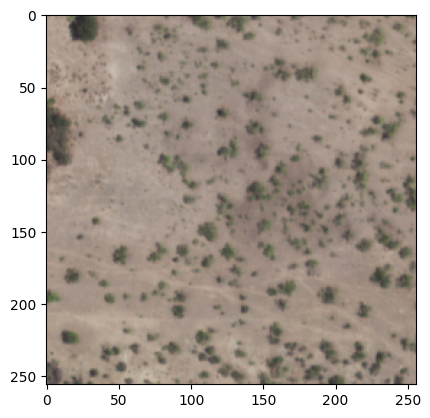

In [63]:
i = 1221
image, ndviImage = getImage(i)

# plt.imshow(ndviImage[:,:,2])
plt.imshow(image)

print(ndviImage[:,:,2].max())
np.quantile(ndviImage[:,:,2],0.99)
## ndvi is too small per pixel (barren)

#### labeling

In [4]:
try:
    labelDict[i]
except KeyError:
    imgList.append(image)
# CHANGE VALUE TO 0 OR 1 BASED ON YOUR DECISION
labelDict[i] = 0 # for example, image 1001 looks pretty green


#### continue when satisfied with labels
##### **& PLEASE SAVE TO CSV**

In [5]:
# might need to make imgList a Numpy Array
# imgArray = np.array(imgList)

# SAVE LABELS TO CSV
# can specify file name as arg 2 to prevent conflicts
labelCSV(labelDict,"testing.csv")

done


## Pull Labeled Images for Training

## Modeling

In [ ]:
image_df = pd.DataFrame(image.reshape(-1, 3), columns=["Red", "Green", "Blue"])
image_df.head()

In [40]:
veg_prob = [0] * 7289 # length of geojson
labeled = []
for val in labelDict.keys():
    veg_prob[val] = labelDict[val]
    labeled.append(val)
veg_prob = np.array(veg_prob)
known_veg_prob = np.array(veg_prob[labeled])

print(len(veg_prob))
print(len(known_veg_prob))


29933
2


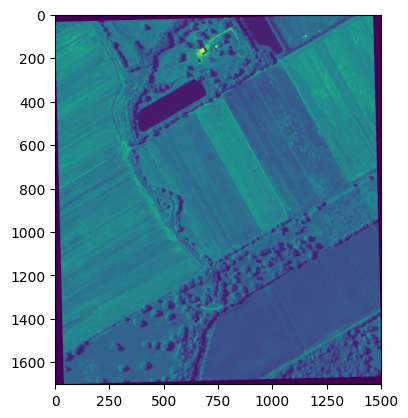

In [7]:
import cv2
cvI = cv2.imread(getImageName(1001))
image = cv2.cvtColor(cvI,cv2.COLOR_RGB2GRAY)
plt.imshow(image)
# cv2.imshow("Image 1001",image)

In [45]:
print(image_df.iloc[:, :3].shape)


(65536, 3)

In [37]:
np.stack(x_train,axis=0).shape
np.array(y_list)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# to get training and testing sets
x_train, y_train, x_val, y_val, x_test, y_test = prep_modelData(csv="400labelsAbs.csv")
img_names = [x for x in os.listdir("./images") if ".tif" in x]

In [45]:
model = Sequential([
Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu", input_shape=(256,256,3)),
MaxPooling2D(),
Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
MaxPooling2D(),
Flatten(),
Dense(64, activation='relu'),
Dense(32, activation='relu'),
Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

346 346
104 104


c:\Users\toliv\Documents\GitHub\pipeline-elevation-project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.fit(x_train, y_train, epochs=10, batch_size=32,validation_data=(x_val,y_val))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6385 - loss: 0.5683 - val_accuracy: 0.5278 - val_loss: 0.8811
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7641 - loss: 0.4749 - val_accuracy: 0.6389 - val_loss: 0.7575
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8524 - loss: 0.4002 - val_accuracy: 0.5556 - val_loss: 0.7154
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8445 - loss: 0.3527 - val_accuracy: 0.5833 - val_loss: 0.6803
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8587 - loss: 0.2644 - val_accuracy: 0.5833 - val_loss: 0.8262
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9029 - loss: 0.2139 - val_accuracy: 0.6111 - val_loss: 0.7496
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9425 - loss: 0.1847 - val_accuracy: 0.6111 - val_loss: 0.6968
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9404 - loss: 0.1530 - val_accuracy: 0.6111 - val_loss:

In [50]:
score = model.evaluate(x_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5676 - loss: 2.3096


## More complex, segmentation/classifying 

### Prep (labels, etc.)

In [70]:
np.array([0]*5).shape
# please work

(5,)

In [105]:
label_map = np.array([
    # (0, 0, 0), # background
    (118, 85, 43), # dirt
    (105, 105, 105), # road
    (47, 79, 79), # building
    (20, 240, 20), # vegetation

])

categoryD = {
    0:label_map[0,:],
    1:label_map[1,:],
    2:label_map[2,:],
    3:label_map[3,:],
    # 4:label_map[4,:],
}

# equation for eyelike color difference from here:
## https://stackoverflow.com/questions/8863810/python-find-similar-colors-best-way
## referencing this article: http://www.compuphase.com/cmetric.htm
def color_difference(i1,i2):
    rmean = int((i1[0]+i2[0])/2)
    r = int(i1[0]+i2[0])
    g = int(i1[1]+i2[1])
    b = int(i1[2]+i2[2])
    return math.sqrt((((512+rmean)*r**2)>>8) + 4*g**2 + (((767-rmean)*b**2)>>8))

def get_cDiff(img):
    diff = np.zeros((256,256,1))
    diffImg = np.zeros((256,256,3))
    cat = np.array([0]*len(label_map))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for n in range(len(cat)):
                cat[n] = color_difference(img[i,j,:],categoryD[n])
            diff[i,j]=cat.argmin()
            diffImg[i,j,:]=label_map[int(diff[i,j])]
    return diff,diffImg

In [100]:
get_cDiff(x_train[0]).max()

2.0

In [107]:
y_cat, y_img = get_cDiff(x_train[0])
# plt.imshow(y_img)
# x_train[0].shape[1]
y_cat

C:\Users\toliv\AppData\Local\Temp\ipykernel_144720\1776292250.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diffImg[i,j,:]=label_map[int(diff[i,j])]


array([[[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       ...,

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]]])

In [67]:
label_map = np.array([
    (0, 0, 0), # background
    (118, 85, 43), # dirt
    (105, 105, 105), # road
    (47, 79, 79), # building
    (20, 240, 20), # vegetation

])

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()
  
    # Create 3 Numpy arrays containing zeros.
    # Later each pixel will be filled with respective red, green, and blue pixels
    # depending on the predicted class.
  
    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)
  
    for label_num in range(0, len(label_map)):
        index = labels == label_num
         
        R, G, B = label_map[label_num]
  
        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B
  
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map
  
  
def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum
  
    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
  
    return image

In [56]:
def load_model(model_name: str):
    if model_name.lower() not in ("resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('resnet_50', 'resnet_101')")
         
    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
  
    elif model_name == "resnet_101":
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    model.eval()
  
    # Warmup run
     
    _ = model(torch.randn(1, 3, 520, 520))
     
    return model, transforms

In [61]:
def perform_inference(model_name: str, num_images=10, image_dir=None, save_images=False, device=None):
     
    if save_images:
        seg_map_save_dir = os.path.join("results", model_name, "segmentation_map")
        overlayed_save_dir = os.path.join("results", model_name, "overlayed_images")
         
        os.makedirs(seg_map_save_dir, exist_ok=True)
        os.makedirs(overlayed_save_dir, exist_ok=True)
     
    device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
    model, transforms = load_model(model_name)
    model.to(device)
  
    # Load image handles for the validation set.
    # val_set_image_names = img_names
    val_set_image_names = [x for x in os.listdir("./images") if ".tif" in x]
  
    # Randomly select 'num_images' from the whole set for inference.
    selected_images = np.random.choice(val_set_image_names, num_images, replace=False)
  
    # Iterate over selected images
    for img_handle in selected_images:
         
        # Load and pre-process image.
        image_name = img_handle
        image_path = os.path.join(image_dir, image_name)
        img_raw = PIL.Image.open(image_path).convert("RGB")
        W, H = img_raw.size[:2]
        img_t = transforms(img_raw)
        img_t = torch.unsqueeze(img_t, dim=0).to(device)
  
        # Model Inference
        with torch.no_grad():
            output = model(img_t)["out"].cpu()
  
        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)
  
        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
        overlayed_image = image_overlay(img_raw, segmented_image)
         
        # Plot
        plt.figure(figsize=(12, 10), dpi=100)
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Image")
        plt.imshow(np.asarray(img_raw))
  
        plt.subplot(1, 3, 2)
        plt.title("Segmentation")
        plt.axis("off")
        plt.imshow(segmented_image)
  
        plt.subplot(1, 3, 3)
        plt.title("Overlayed")
        plt.axis("off")
        plt.imshow(overlayed_image[:, :, ::-1])
         
        plt.show()
        plt.close()
  
        # Save Segmented and overlayed images
        if save_images:
            cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
            cv2.imwrite(overlayed_save_dir, overlayed_image)
  
    return

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


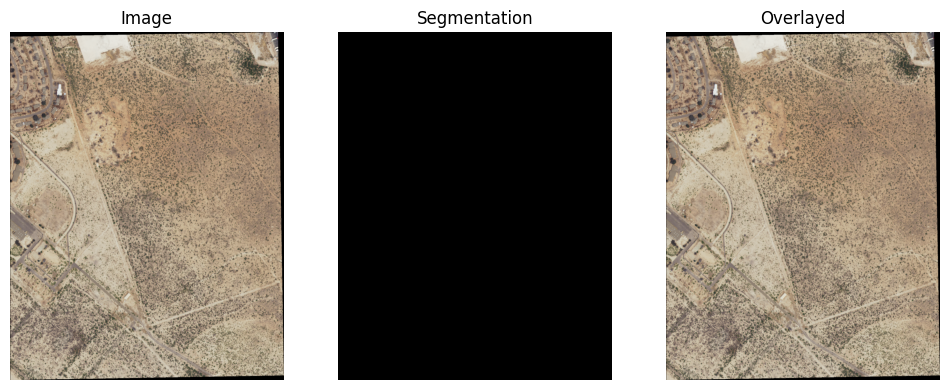

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


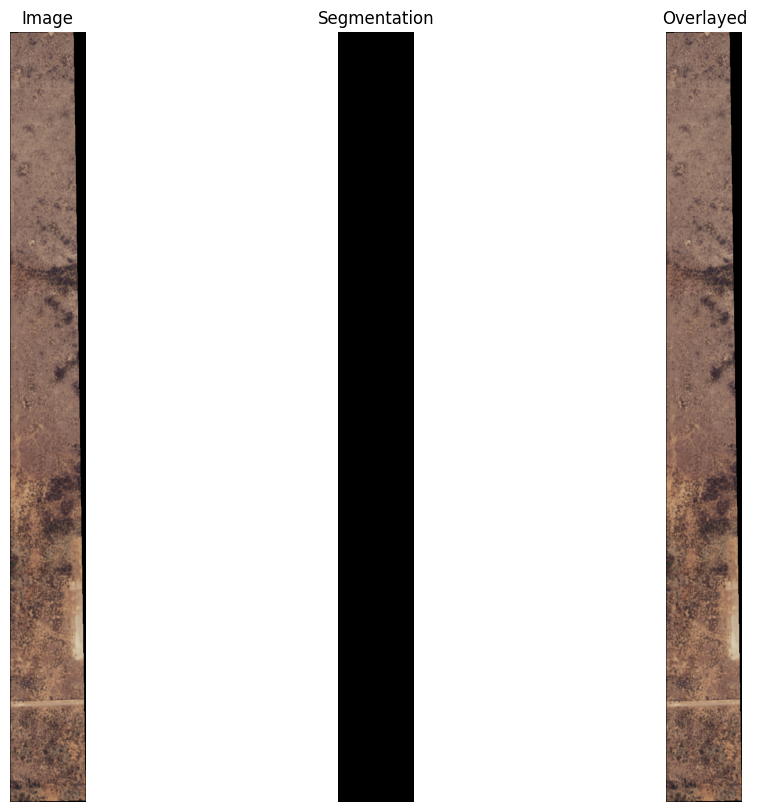

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


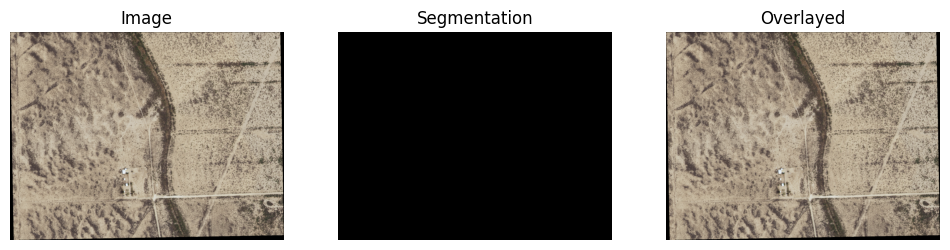

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


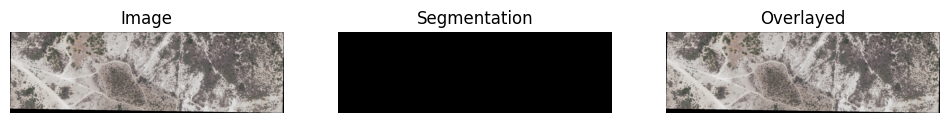

In [68]:
ROOT_raw_image_directory = r"./images"
  
model_name = 'resnet_50' # "resnet_50", resnet_101
num_images = 4
save = False
  
perform_inference(
    model_name=model_name, 
    num_images=num_images, 
    save_images=save, 
    image_dir=ROOT_raw_image_directory
)

### Actual data